In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

In [2]:
import requests
import io
import os

def _csv_from_path_or_url(path, url):
    if os.path.isfile(path):
        return path
    else:
        r = requests.get(url)
        r.raise_for_status()
        # After fetching from the URL, cache at the path
        contents = r.text
        with open(path, "w") as f:
            f.write(contents)
        return path

In [3]:
import inspect
def format_fit_vars(ansatz, fit_, cov=None):
    arg_names = inspect.getargs(ansatz.__code__).args[1:]
    stddevs = np.sqrt(cov.diagonal()) if cov is not None else [np.inf]*len(fit_)
    values = zip(arg_names, fit_, stddevs)
    return " ".join(f"{arg}={val:0.2f}±{std:0.1f}" for (arg, val, std) in values)

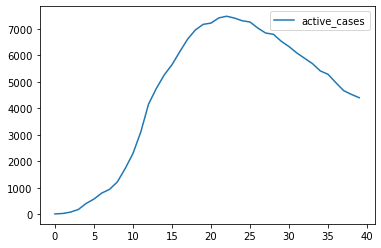

In [4]:
csv = _csv_from_path_or_url(
    path="south-korea-active-cases.csv",
    url="https://qbin.io/bs-mixed-gv7a/raw",
)
df = pd.read_csv(csv)

seconds_per_day = 24*3600
df['seconds_since_feb_17'] = 24*3600*df['days_since_feb_17']

df.plot(y='active_cases')

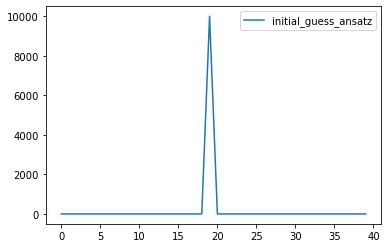

In [8]:
def gaussian(x, a, b, m, y0):
    return y0 + a * np.exp(-(x - m)**2 / b)
gaussian.initial_guess = [1e4, 20*seconds_per_day, 20*seconds_per_day, 1]

def gaussian_dusty(x, y0, A, w, xc):
    four_ln2 = 4 * np.log(2)
    norm_denom = w * np.sqrt(np.pi / four_ln2)
    return y0 + A / norm_denom * np.exp(-four_ln2*((x - xc)/w)**2)
gaussian_dusty.initial_guess = [1, 1, 1, 1]

ansatz = gaussian
initial_guess_df = pd.DataFrame(
    {'initial_guess_ansatz': [ansatz(x, *ansatz.initial_guess) for x in df['seconds_since_feb_17']]},
    index=df.index,
)
initial_guess_ax = initial_guess_df.plot(y=['initial_guess_ansatz'])

a=-124458534.94±inf b=1728000.00±inf m=-835253938485.66±inf y0=3109.48±inf


/usr/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


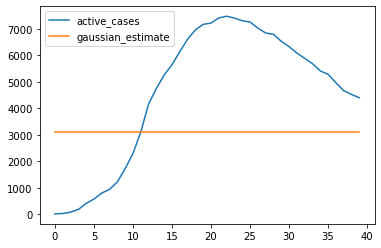

In [6]:
data_kept = df[df['seconds_since_feb_17'] < 30*(2600*24)]
(fit_, cov) = curve_fit(
    ansatz,
    xdata=data_kept['seconds_since_feb_17'],
    ydata=data_kept['active_cases'],
    p0=ansatz.initial_guess if hasattr(ansatz, 'initial_guess') else None,
)
print(format_fit_vars(ansatz, fit_, cov))
df['gaussian_estimate'] = [ansatz(x, *fit_) for x in df['seconds_since_feb_17']]
ax = df.plot(y=['active_cases', 'gaussian_estimate'])